## Demo PyHeat Youri & Mathis

Ceci est une notebook de démo pour la lib pyheat.
C'est une version temporaire

Toutes les valeurs utilisées dans ce notebook sont totalement arbitraires.
L'objectif n'est pas de montré des résultats mais le fonctionnement de la lib et ses entrées/sorties.

In [34]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np

In [35]:
from datetime import datetime

times = [datetime.fromtimestamp(1000*k) for k in range(500)]
var = np.stack(
    4*[np.cos(np.linspace(0,2*np.pi,500))],
    axis = -1
)
temps = np.array(500*[[310.15, 308, 306, 285.15]])+2*var

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.15, .25, .4], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .05,
    "dH_measures": list(zip(times,list(zip(-.01*np.cos(np.linspace(0,2*np.pi,500))+.03, temps[:,0])))),
	"T_measures": list(zip(times, temps[:,1:])),
    "sigma_meas_P": None, #float
    "sigma_meas_T": None, #float
}

col = Column.from_dict(col_dict)

In [36]:
try:
    col.get_depths_solve()
except ComputationOrderException as e:
    print(e)
    
try:
    col.get_all_n()
except ComputationOrderException as e:
    print(e)

compute_solve_transi has to be computed before calling get_depths_solve.
compute_mcmc has to be computed before calling get_all_n.


In [37]:
#Peut définir un tuple avec la class Param (NamedTuple)
params = Param(
    moinslog10K = 4,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

#Ou en tuple plus classiquement
params_tuple = (4, .1, 2, 4e6)

assert params == params_tuple

In [38]:
col.compute_solve_transi(params, 100)

temps = col.temps_solve

col.compute_solve_transi(params_tuple, 100)

temps_from_tuple = col.temps_solve

assert np.array_equal(temps, temps_from_tuple)

Text(0, 0.5, 'depth (m)')

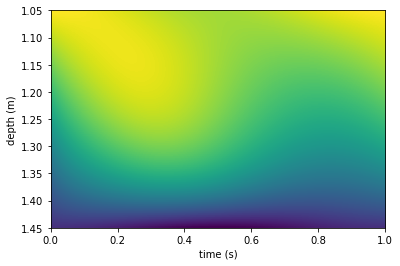

In [40]:
#Tout est stocké dans la class col pour ne pas avoir à le stocker hors de la class
fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve[:].T,
    aspect = "auto",
    extent = [0, 1, col.depths_solve[-1], col.depths_solve[0]], #TODO : trouver comment monter le datetime
)

ax.set_xlabel("time (s)")
ax.set_ylabel("depth (m)")

Text(0, 0.5, 'temperature (K)')

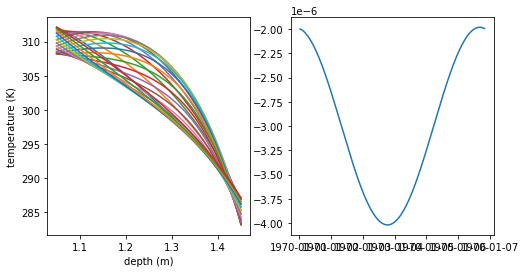

In [7]:
from itertools import islice

fig, axs = plt.subplots(1, 2, figsize=(8,4),facecolor = 'w')

ite = zip(
    col.temps_solve,
    col.times_solve
)
for temps, t in islice(ite, 20, None, 20):
    axs[0].plot(
        col.depths_solve,
        temps,
        label = f"{t:.1e}"
    )
axs[1].plot(
    col.times_solve,
    col.flows_solve,
    label = f"{t:.1e}"
)

axs[0].set_xlabel("depth (m)")
axs[0].set_ylabel("temperature (K)")
#axs[1].legend()

Index 23 in z_array -> 1.142929292929293
Temp at index 23 and t = 0 -> 306.342
Temp at 1.143 -> 306.342
col.get_temps correct inaccuracy in z.
Temp at 1.144 -> 306.342


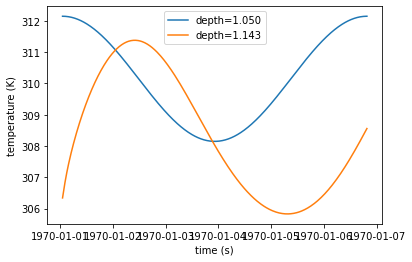

In [23]:
ind = 23
print(f"Index {ind} in z_array -> {col.depths_solve[ind]}")
print(f"Temp at index {ind} and t = 0 -> {col.temps_solve[0, ind]:.3f}")
print(f"Temp at {col.depths_solve[ind]:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind])[0]:.3f}")
print("col.get_temps correct inaccuracy in z.")
print(f"Temp at {col.depths_solve[ind]+1e-3:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind]+1e-4)[0]:.3f}")

fig, ax = plt.subplots(facecolor = 'w')
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[0]), label = f"depth={col.depths_solve[0]:.3f}")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind]), label = f"depth={col.depths_solve[ind]:.3f}")
ax.set_xlabel("time (s)")
ax.set_ylabel("temperature (K)")
ax.legend()
#TODO : Faire la meme avec le temps en paramètre

In [24]:
priors = {
    "moinslog10K": ((1.5, 6), .005), # (intervalle, sigma)
    "n": ((.01, .25), .005),
    "lambda_s": ((1, 5), .05),
    "rhos_cs": ((1e6,1e7), 1e4),
}

col.compute_mcmc(
    nb_iter = 4000,
    priors = priors,
    nb_cells = 100,
    quantile = (.05, .5, .95)
)

Mcmc Computation : 100%|██████████| 4000/4000 [03:13<00:00, 20.69it/s]


Normal si les resultats ont pas de sens


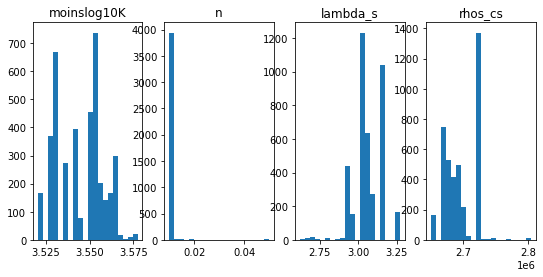

In [27]:
print("Normal si les resultats ont pas de sens")

fig, axes = plt.subplots(1, 4, figsize = (9,4), facecolor = 'w')

ite = zip(
    ["moinslog10K", "n", "lambda_s", "rhos_cs"],
    [col.all_moinslog10K, col.all_n, col.all_lambda_s, col.all_rhos_cs] 
)

for (lbl, vals), ax in zip(ite, axes):
    ax.hist(vals, bins = 20)
    ax.set_title(lbl)
#col.get_all_n() et ses dérivés sont aussi dispo sous forme de méthodes

Text(0, 0.5, 'acceptance')

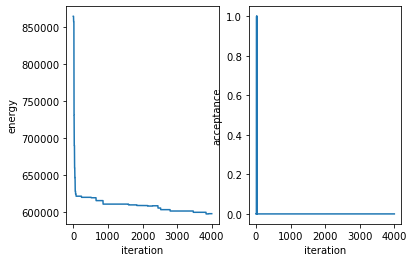

In [31]:
fig, axs = plt.subplots(1,2,facecolor = 'w')
axs[0].plot(col.all_energy)
axs[1].plot(col.all_acceptance_ratio)

axs[0].set_xlabel("iteration")
axs[0].set_ylabel("energy")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("acceptance")

Parametres(moinslog10K=3.5207245347491174, n=0.011410203233590396, lambda_s=3.251084291685928, rhos_cs=2655187.1418341002)


Text(0, 0.5, 'time (s)')

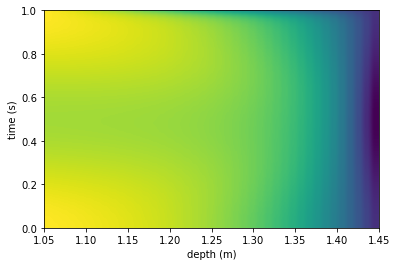

In [32]:
#Can also sample param from mcmc trajectory
sampled_params = col.get_best_param()
print(sampled_params)

col.compute_solve_transi(sampled_params, 41)

fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [col.depths_solve[0], col.depths_solve[-1], 0, 1]
)

ax.set_xlabel("depth (m)")
ax.set_ylabel("time (s)")

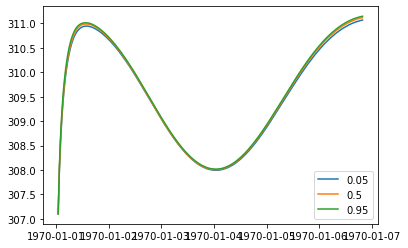

In [33]:
fig, ax = plt.subplots(facecolor = 'w')

#Pas encore possible de donner le temps encore.
for quant in (.05,.5,.95):
    ax.plot(
        col.times_mcmc,
        col.get_temps_quantile(quant)[:,20],
        label = quant
    )
    
ax.legend()